In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from findthegap.gapper import Gapper
import torch

%matplotlib inline

In [2]:
data=np.loadtxt("/users/caganze/mock_data.csv", delimiter=",")
data_st=np.loadtxt("/users/caganze/mock_data_with_stream.csv", delimiter=",")

xd, yd=data[:,0], data[:,1]
grid_data=np.vstack([np.linspace(xd.min(), xd.max(), 100),
                     np.linspace(yd.min(), yd.max(), 100)]).T

In [3]:
def kde_scipy(bw, data, grid):
    xx, yy = np.meshgrid(grid[0], grid[1])
    values = np.vstack([data[0], data[1]])
    kernel = stats.gaussian_kde(values, bw_method=bw)
    return kernel.evaluate([xx.ravel(), yy.ravel()]).reshape(xx.shape)

def density_with_gappy(bw, data, grid):
    #some resgape
    bounds = np.array([[np.min(data[:,d]),np.max(data[:,d])] for d in range(data.shape[1])])
    grid_linspace = [ grid[:,d] for d in range(2) ]
    meshgrid = np.meshgrid(*grid_linspace, indexing='ij')
    meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in meshgrid]
    grid_data = np.hstack(meshgrid_ravel)
    
    gapper_base = Gapper(data, bw, bounds)
    #print (gapper_base)
    grid_density = gapper_base.kde.score_samples(torch.tensor(grid_data))
   
    #density matrix 
    return grid_density.reshape((len(grid[:,0]), len(grid[:,1]))).T


In [4]:
#my stuff
def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y):
    #scaled to 1 instead of normalized to 1
    dens=np.exp(-(x-x0)**2/(2*sigma_x**2) -(y-y0)**2/(2*sigma_y**2))
    return dens/np.nanmax(dens)

def gaussian_kde_2d(data, grid, bw):
    #loop over all grid points
    # multiply the number of datapoints by a 2d-gaussian with STD= bw centered around the grid points
    #average all the gaussians
    #obviously bad solutions for large N and many dimesions
    xg, yg = np.meshgrid(grid[0], grid[1])
    densities=[]
    for idx in range(len(grid[0])-1):
        for idy in range(len(grid[1])-1):
            #count data points
            subdata = data[0][np.logical_and.reduce([data[0]>= grid[0][idx],
                                               data[0]<grid[0][idx+1],
                                               data[1]>= grid[1][idy],
                                               data[1]<grid[1][idy+1]])]
            center= grid[0][idx], grid[1][idy]
            dens=len(subdata)*gaussian_2d(xg, yg, center[0], center[1], bw, bw)
            
            densities.append(dens)
    #ignore edges for now?
    return np.nanmean(densities, axis=0)


In [5]:
bw=0.7
my_dens= gaussian_kde_2d(np.array([xd, yd]), np.array([grid_data[:,0], grid_data[:,1]]), bw)
scipy_dens=kde_scipy(bw, np.array([xd, yd]), np.array([grid_data[:,0], grid_data[:,1]]))
dens_gappy=density_with_gappy(bw, np.array([xd, yd]).T, grid_data)

In [6]:
dens_gappy.shape

torch.Size([100, 100])

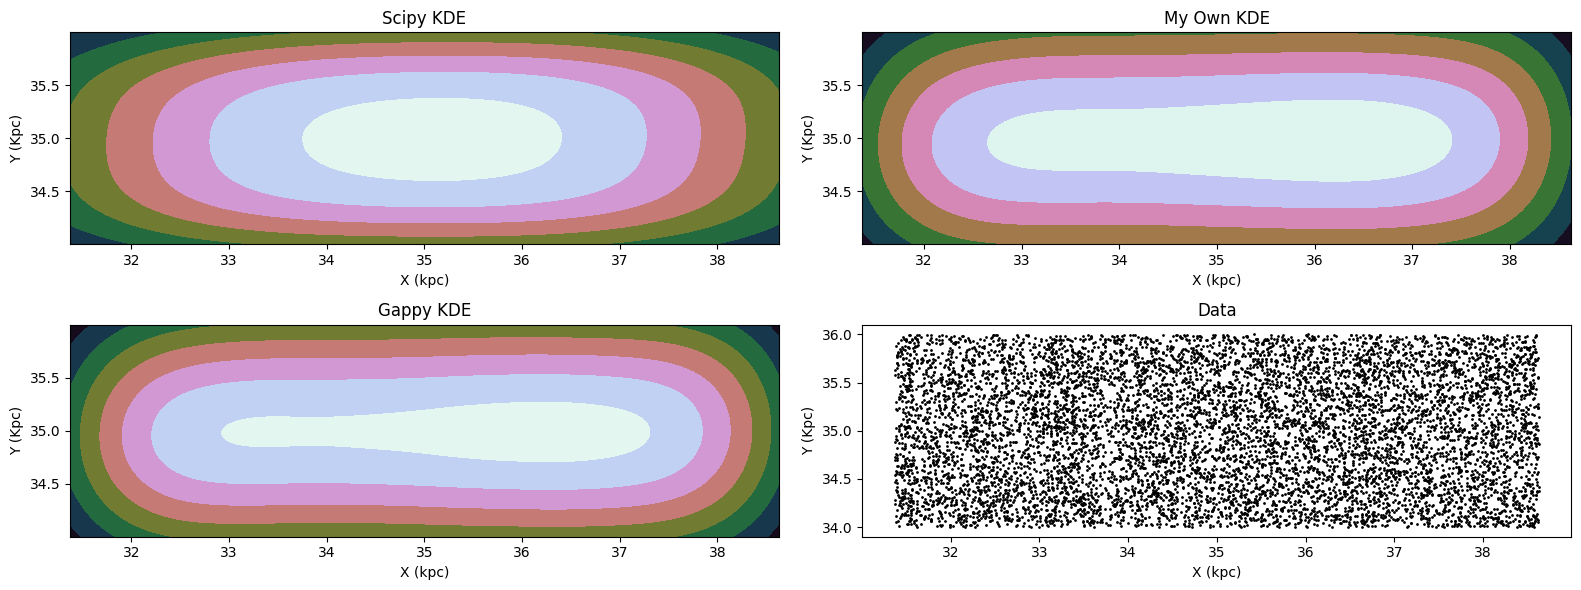

In [7]:
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(16,6))

ax[0][0].contourf(grid_data[:,0], grid_data[:,1], scipy_dens, cmap='cubehelix')
ax[0][1].contourf(grid_data[:,0], grid_data[:,1], my_dens, cmap='cubehelix')
ax[1][0].contourf(grid_data[:,0], grid_data[:,1], dens_gappy, cmap='cubehelix')

ax[1][1].scatter(data[:,0], data[:,1], s=1., c='k')
plt.tight_layout()

for a in np.concatenate(ax):
    a.set(xlabel='X (kpc)', ylabel= 'Y (Kpc)')

ax[0][0].set(title='Scipy KDE')
ax[0][1].set(title='My Own KDE')
ax[1][0].set(title='Gappy KDE')
ax[-1][-1].set(title='Data')

plt.tight_layout()
#a.set(xlabel='X (kpc)', ylabel= 'Y (Kpc)')
plt.savefig('../figures/kdes_bckd.jpeg', bbox_inches='tight')

In [8]:
bw=0.7
my_dens= gaussian_kde_2d(np.array([data_st[:,0], data_st[:,1]]), np.array([grid_data[:,0], grid_data[:,1]]), bw)
scipy_dens=kde_scipy(bw, np.array([data_st[:,0], data_st[:,1]]), np.array([grid_data[:,0], grid_data[:,1]]))
dens_gappy=density_with_gappy(bw, data_st, grid_data)

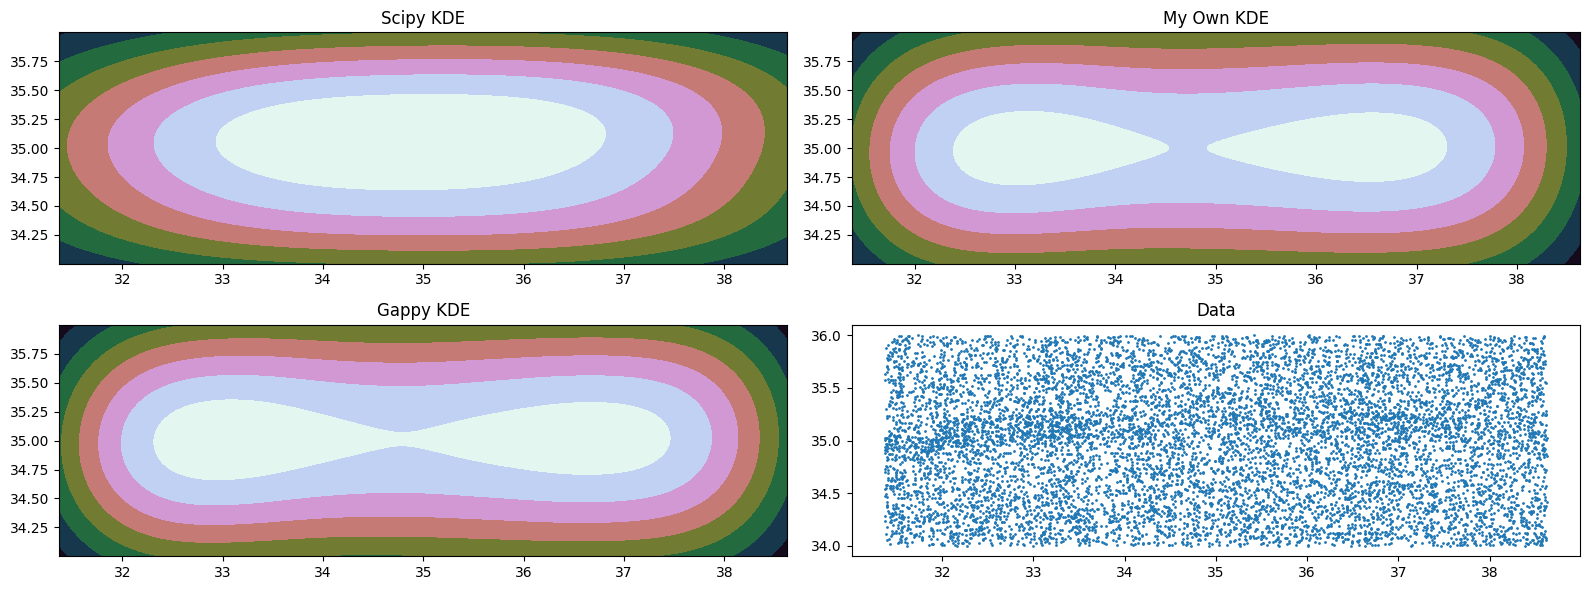

In [9]:
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(16,6) )

ax[0][0].contourf(grid_data[:,0], grid_data[:,1], scipy_dens, cmap='cubehelix')
ax[0][1].contourf(grid_data[:,0], grid_data[:,1], my_dens, cmap='cubehelix')
ax[1][0].contourf(grid_data[:,0], grid_data[:,1], dens_gappy, cmap='cubehelix')

ax[-1][-1].scatter(data_st[:,0], data_st[:,1], s=1.)
plt.tight_layout()


ax[0][0].set(title='Scipy KDE')
ax[0][1].set(title='My Own KDE')
ax[1][0].set(title='Gappy KDE')
ax[-1][-1].set(title='Data')

plt.tight_layout()
#a.set(xlabel='X (kpc)', ylabel= 'Y (Kpc)')
plt.savefig('../figures/kdes_withstream.jpeg', bbox_inches='tight')

In [10]:
bw=0.05
my_dens= gaussian_kde_2d(np.array([data_st[:,0], data_st[:,1]]), np.array([grid_data[:,0], grid_data[:,1]]), bw)
scipy_dens=kde_scipy(bw, np.array([data_st[:,0], data_st[:,1]]), np.array([grid_data[:,0], grid_data[:,1]]))
dens_gappy=density_with_gappy(bw, data_st, grid_data)

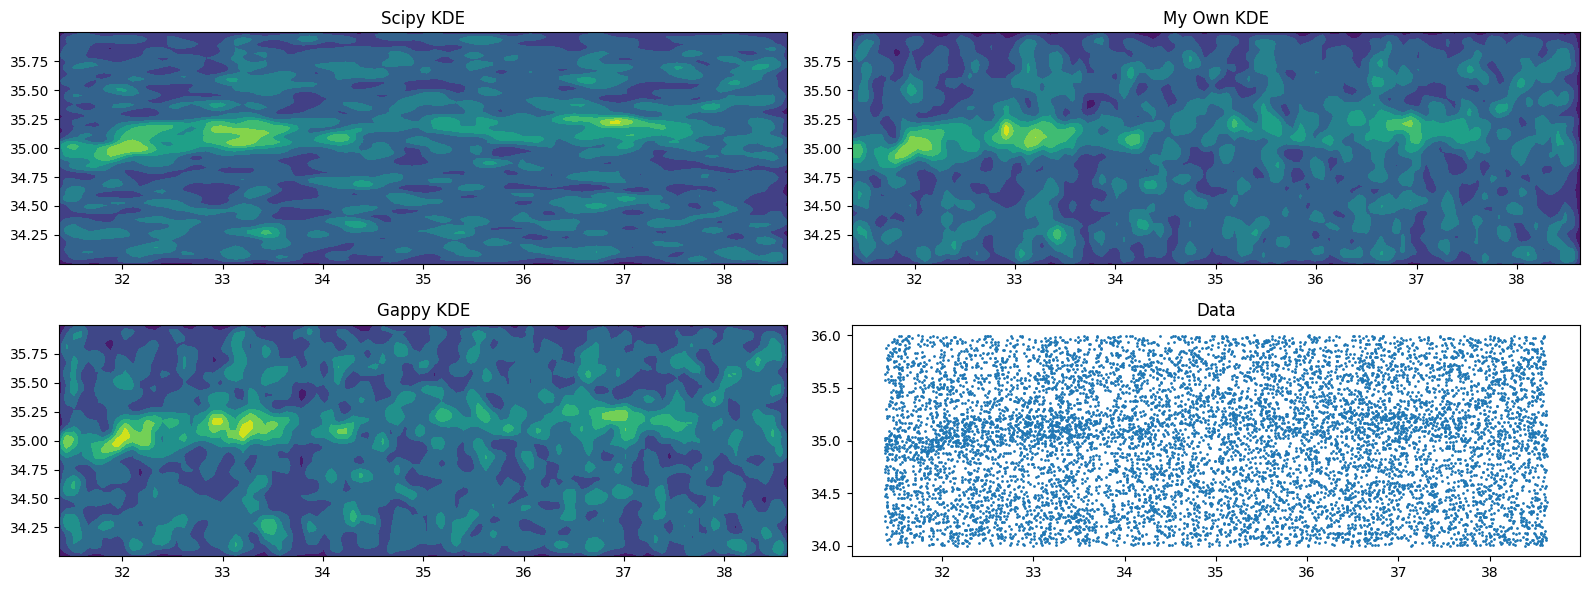

In [11]:
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(16,6))

ax[0][0].contourf(grid_data[:,0], grid_data[:,1], scipy_dens)
ax[0][1].contourf(grid_data[:,0], grid_data[:,1], my_dens)
ax[1][0].contourf(grid_data[:,0], grid_data[:,1], dens_gappy)

ax[-1][-1].scatter(data_st[:,0], data_st[:,1], s=1.)
plt.tight_layout()


ax[0][0].set(title='Scipy KDE')
ax[0][1].set(title='My Own KDE')
ax[1][0].set(title='Gappy KDE')
ax[-1][-1].set(title='Data')

plt.tight_layout()
#a.set(xlabel='X (kpc)', ylabel= 'Y (Kpc)')

In [12]:
grid_data[:,0][0]-grid_data[:,0][1]

-0.07330852980733482